## Часть 1
Напишите скрипт, который скачивает все данные прошедших губернаторских выборов для всех избирательных участков. 

Входная точка [по ссылке](http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

In [1]:
import lxml.html
import lxml.etree
import requests
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline

In [2]:
request = requests.get("http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222")
tree = lxml.html.fromstring(request.text)

terr = tree.xpath('//a[@style = "text-decoration: none"]')
df = pd.DataFrame()
pattern = re.compile(r'(.+)%')

In [3]:
for tik in range(30):
    request = requests.get(terr[tik].attrib['href'])
    tree = lxml.html.fromstring(request.text)

    uik = tree.xpath('/html/body/table[@style = "padding-left: 3px; padding-right: 3px;"]/tr[@height = "100%"]/td/table[@style = "width:100%;border-color:#000000"]/tr/td[2]/div/table/tr[1]/td//text()')
    data = []
    data.append([terr[tik].text]*len(uik))
    data.append(uik)

    for i in range(2,13):
        cell = tree.xpath(f'/html/body/table[@style = "padding-left: 3px; padding-right: 3px;"]/tr[@height = "100%"]/td/table[@style = "width:100%;border-color:#000000"]/tr/td[2]/div/table/tr[{i}]/td//b/text()')
        data.append(cell)

    for i in range(14,17):
        cell = tree.xpath(f'/html/body/table[@style = "padding-left: 3px; padding-right: 3px;"]/tr[@height = "100%"]/td/table[@style = "width:100%;border-color:#000000"]/tr/td[2]/div/table/tr[{i}]/td//b/text()')
        data.append(cell)
        cell = tree.xpath(f'/html/body/table[@style = "padding-left: 3px; padding-right: 3px;"]/tr[@height = "100%"]/td/table[@style = "width:100%;border-color:#000000"]/tr/td[2]/div/table/tr[{i}]/td')
        cell = list(map(lambda x:pattern.findall(x.text_content())[0],cell))
        data.append(cell)


    df = df.append(pd.DataFrame(data).transpose(),ignore_index = True)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Территориальная избирательная комиссия №1,УИК №1,1803,1200,587,11,602,11,587,23,575,0,0,110,18.39,345,57.69,120,20.07
1,Территориальная избирательная комиссия №1,УИК №2,1466,1100,433,14,653,14,430,19,425,0,0,53,11.94,326,73.42,46,10.36
2,Территориальная избирательная комиссия №1,УИК №3,2092,1600,576,22,1002,22,576,15,583,0,0,155,25.92,332,55.52,96,16.05
3,Территориальная избирательная комиссия №1,УИК №4,1056,1000,318,4,678,4,318,13,309,0,0,67,20.81,171,53.11,71,22.05
4,Территориальная избирательная комиссия №1,УИК №5,1827,1400,495,8,897,8,493,16,485,0,0,137,27.35,266,53.09,82,16.37


In [5]:
title = ['Комиссия', 'УИК']
for i in range(2,13):
    cell = tree.xpath(f'/html/body/table[@style = "padding-left: 3px; padding-right: 3px;"]/tr[@height = "100%"]/td/table[@style = "width:100%;border-color:#000000"]/tr/td[1]/table/tr[{i}]/td[@align = "left"]/nobr/text()')
    title.append(cell[0])

for i in range(14,17):
    cell = tree.xpath(f'/html/body/table[@style = "padding-left: 3px; padding-right: 3px;"]/tr[@height = "100%"]/td/table[@style = "width:100%;border-color:#000000"]/tr/td[1]/table/tr[{i}]/td[@align = "left"]/nobr/text()')
    title.append(cell[0])
    title.append(cell[0] + ' %')

In [6]:
df.columns = title
df.head()

,Комиссия,УИК,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Амосов Михаил Иванович %,Беглов Александр Дмитриевич,Беглов Александр Дмитриевич %,Тихонова Надежда Геннадьевна,Тихонова Надежда Геннадьевна %
0,Территориальная избирательная комиссия №1,УИК №1,1803,1200,587,11,602,11,587,23,575,0,0,110,18.39,345,57.69,120,20.07
1,Территориальная избирательная комиссия №1,УИК №2,1466,1100,433,14,653,14,430,19,425,0,0,53,11.94,326,73.42,46,10.36
2,Территориальная избирательная комиссия №1,УИК №3,2092,1600,576,22,1002,22,576,15,583,0,0,155,25.92,332,55.52,96,16.05
3,Территориальная избирательная комиссия №1,УИК №4,1056,1000,318,4,678,4,318,13,309,0,0,67,20.81,171,53.11,71,22.05
4,Территориальная избирательная комиссия №1,УИК №5,1827,1400,495,8,897,8,493,16,485,0,0,137,27.35,266,53.09,82,16.37


In [7]:
df.to_csv('parsed.csv', index=None)

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

#### 1) явку (%) по всем ТИК, результат отсортировать по убыванию

In [8]:
df = pd.read_csv('parsed.csv')
df.head()

,Комиссия,УИК,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Амосов Михаил Иванович %,Беглов Александр Дмитриевич,Беглов Александр Дмитриевич %,Тихонова Надежда Геннадьевна,Тихонова Надежда Геннадьевна %
0,Территориальная избирательная комиссия №1,УИК №1,1803,1200,587,11,602,11,587,23,575,0,0,110,18.39,345,57.69,120,20.07
1,Территориальная избирательная комиссия №1,УИК №2,1466,1100,433,14,653,14,430,19,425,0,0,53,11.94,326,73.42,46,10.36
2,Территориальная избирательная комиссия №1,УИК №3,2092,1600,576,22,1002,22,576,15,583,0,0,155,25.92,332,55.52,96,16.05
3,Территориальная избирательная комиссия №1,УИК №4,1056,1000,318,4,678,4,318,13,309,0,0,67,20.81,171,53.11,71,22.05
4,Территориальная избирательная комиссия №1,УИК №5,1827,1400,495,8,897,8,493,16,485,0,0,137,27.35,266,53.09,82,16.37


In [9]:
tiks = df.groupby('Комиссия').sum()
tiks['Явка %'] = round(100 * (tiks.iloc[:,2] + tiks.iloc[:,3]) / tiks.iloc[:,0], 2)
tiks.head(3)

,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Амосов Михаил Иванович %,Беглов Александр Дмитриевич,Беглов Александр Дмитриевич %,Тихонова Надежда Геннадьевна,Тихонова Надежда Геннадьевна %,Явка %
Комиссия,,,,,,,,,,,,,,,,,,
Территориальная избирательная комиссия №1,105510,83250,31626,1592,50032,1590,31437,1220,31807,0,0,6206,1129.91,19818,3725.32,5783,1029.15,31.48
Территориальная избирательная комиссия №10,93291,80300,27411,1059,51830,1057,27375,681,27751,0,0,4104,702.10,19296,3041.88,4351,737.82,30.52
Территориальная избирательная комиссия №11,212151,176435,55603,1417,119415,1415,55280,1503,55192,0,0,10958,1938.88,34772,6161.81,9462,1636.00,26.88


In [10]:
tiks = tiks.sort_values(by=['Явка %'],ascending = False)
tiks.head(3)

,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Амосов Михаил Иванович %,Беглов Александр Дмитриевич,Беглов Александр Дмитриевич %,Тихонова Надежда Геннадьевна,Тихонова Надежда Геннадьевна %,Явка %
Комиссия,,,,,,,,,,,,,,,,,,
Территориальная избирательная комиссия №18,94434,67559,47349,1314,18896,1314,46600,1076,46838,0,0,5753,701.72,36632,4116.17,4453,548.85,51.53
Территориальная избирательная комиссия №15,35191,27750,13329,752,13669,752,13327,394,13685,0,0,1718,368.79,9780,2111.35,2187,435.71,40.01
Территориальная избирательная комиссия №13,47955,40450,17519,1506,21424,1506,17506,556,18456,1,0,2597,504.17,13274,2585.74,2585,502.91,39.67


#### 2) выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат (%, учитывать участки на которых проголосовало больше 100 человек)
#### Амосов Михаил Иванович

In [11]:
df[df['Число действительных избирательных бюллетеней']>100].loc[df['Амосов Михаил Иванович %'].idxmax()].iloc[[0,1,-5]]

Комиссия                    Территориальная избирательная комиссия №17
УИК                                                           УИК №567
Амосов Михаил Иванович %                                         41.52
Name: 1085, dtype: object

#### 3) найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

In [12]:
df['Явка%'] = round(100 * (df.iloc[:,4] + df.iloc[:,5]) / df.iloc[:,2], 2)

In [13]:
razn = df.groupby('Комиссия')['Явка%'].agg(['max','min'])
razn['max-min'] = razn['max'] - razn['min']
razn.loc[razn['max-min'].idxmax()]

max        100.00
min         17.96
max-min     82.04
Name: Территориальная избирательная комиссия №17, dtype: float64

#### 4) посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

In [14]:
df['Явка'] = round((df.iloc[:,4] + df.iloc[:,5]) / df.iloc[:,2], 2)
df.groupby('Комиссия')['Явка'].agg(['var']).sort_values(by=['var'])

,var
Комиссия,
Территориальная избирательная комиссия №25,0.000897
Территориальная избирательная комиссия №6,0.002033
Территориальная избирательная комиссия №14,0.003128
Территориальная избирательная комиссия №12,0.003269
Территориальная избирательная комиссия №7,0.007175
Территориальная избирательная комиссия №10,0.007317
Территориальная избирательная комиссия №3,0.007450
Территориальная избирательная комиссия №16,0.011206
Территориальная избирательная комиссия №9,0.011807


#### 5) для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат

In [15]:
df['Тихонова Надежда Геннадьевна %'] = df['Тихонова Надежда Геннадьевна %'].apply(lambda x: round(x))
x = df['Тихонова Надежда Геннадьевна %'].value_counts(sort = False)
tihonova = pd.DataFrame(x)
tihonova.columns = ['count(YIK)']
tihonova.index.names = ['Тихонова %']
tihonova

,count(YIK)
Тихонова %,
0,2
1,4
2,5
3,11
4,10
5,14
6,21
7,22
8,35


In [16]:
df['Беглов Александр Дмитриевич %'] = df['Беглов Александр Дмитриевич %'].apply(lambda x: round(x))
x = df['Беглов Александр Дмитриевич %'].value_counts(sort = False)
beglov = pd.DataFrame(x)
beglov.columns = ['count(YIK)']
beglov.index.names = ['Беглов %']
beglov

,count(YIK)
Беглов %,
30,1
32,1
33,2
38,3
39,3
...,...
93,1
94,3
95,2


In [17]:
df['Амосов Михаил Иванович %'] = df['Амосов Михаил Иванович %'].apply(lambda x: round(x))
x = df['Амосов Михаил Иванович %'].value_counts(sort = False)
amosov = pd.DataFrame(x)
amosov.columns = ['count(YIK)']
amosov.index.names = ['Амосов %']
amosov

,count(YIK)
Амосов %,
0,1
1,6
2,6
3,2
4,13
5,18
6,26
7,34
8,48


#### 6) визуализируйте отношение - явка на УИК  →  результат кандидата.

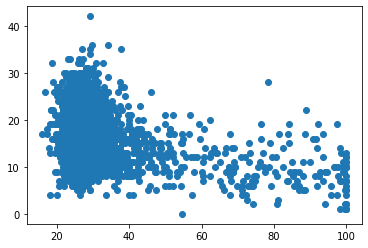

In [18]:
x = df['Явка%']
y = df['Амосов Михаил Иванович %']
plt.scatter(x,y)

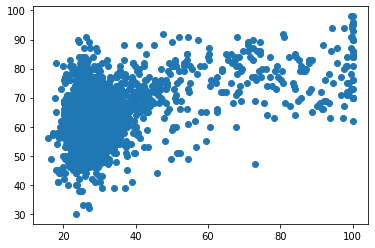

In [19]:
x = df['Явка%']
y = df['Беглов Александр Дмитриевич %']
plt.scatter(x,y)

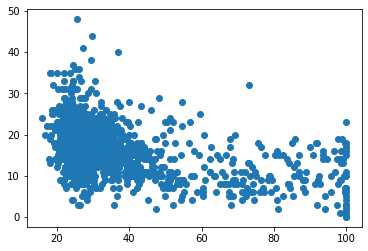

In [20]:
x=df['Явка%']
y=df['Тихонова Надежда Геннадьевна %']
plt.scatter(x,y)